# Данные

Данные в файле covid_flow.pkl
Данные включают поток пациентов с подтвержденным COVID-19 в ковидные стационары НИМЦ
Алмазова, Санкт-Петербург.

Датасет включает 1992 случая стационарного лечения COVID-19. Данные включают

•
Многомерные временные ряды, описывающие состояние пациента (интервал неделя)

•
План лечения (препараты и процедуры) для каждого пациента

•
Исходы лечения

Процесс стационарного лечения включает в себя два подпроцесса – контролирующий и контролируемый. 

Контролирующий –
назначение препаратов и процедур. 
Контролируемый – процесс изменения состояния пациентов.

Процесс лечения
включает в себя контролирующий процесс (назначение препарат и процедур) и контролируемый
процесс (процесс изменения состояния пациентов)

_stat_control – стационарные признаки, которые описывают контролирующий
процесс и не меняются (в covid_flow это бинарные признаки включения 1 или
невключения 0 препарата в план лечения)

_dinam_control – динамические признаки, которые описывают контролирующий
процесс и меняются (в covid_flow это бинарные признаки включения 1 или
невключения 0 процедуры в план лечения)

_stat_fact – стационарные признаки, которые описывают контролируемый процесс
и не меняются (в covid_flow это признаки, описывающие пациентов, пол, возраст, и
все остальное что не меняется)

_dinam_fact – динамические признаки, которые описывают контролирующий
процесс и меняются (в covid_flow это признаки описывающие состояние
пациентов, например температура, % поражения легких и другое)

t_point – индикатор временного интервала. Вся длительность процесса разбита на
равные интервалы времени, t_point – метка интервала.

end_epizode – индикатор конца процесса, 0 – процесс лечения не окончен в
данном t_point, 1 – окончен

case (index) – уникальный идентификатор наблюдения (процесса), пример –
«GACAk+Q»

long_observation_tar – длинна процесса

current_process_duration – текущая длинна процесса (на момент t_point)

outcome_tar – исход лечения, 1- летальный, 0 – выздоровление.

# Прогноза значения индикатора пациента
Прогноз проходит в следующем периоде по иформации о
текущем состоянии и предыдущих состояниях. 
Таргеты – признаки с префиксами
_dinam_fact. 
Факторы – все признаки кроме тех что с префиксами _tar. 

1) Для начала нужен литературный обзор существующих методов. 
2) Далее берешь пару существующих методов, пробуешь применить и переложить на данные. Хочется чтобы были попробованны рекурентные нейронные сети, и AutoML подход Fedot
)(https://github.com/nccr-itmo/FEDOT), но в целом ограничений на методы нет. 
3) На выходе нужен класс, который умеет принимать информацию о прошлых состояниях пациента, и
прогнозировать следующее. Читаемость и чистота кода крайне приветствуется. 

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from time import time
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline

import math
import keras
import pickle
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from keras.metrics import RootMeanSquaredError

In [ ]:
df = None
with open("covid_flow.pkl", "rb") as f:
    df = pickle.load(f)
df["case"] = df.index
df["t_point"] = df["t_point"].apply(lambda x: x[2:])
df["t_point"] = df["t_point"].apply(lambda x: int(x))
df.set_index(["case", "t_point"], inplace=True)
df.sort_index()


омепразол_stat_control  надропарин кальция_stat_control  \
case    t_point                                                            
GACAAcY 0                             1                                1   
        1                             1                                1   
        2                             1                                1   
        3                             1                                1   
GACAAnf 0                             1                                1   
...                                 ...                              ...   
GACBB;O 0                             0                                0   
        1                             0                                0   
GACXAAB 0                             1                                0   
        1                             1                                0   
        2                             1                                0   

                 эзомепразол_stat_control  амлодипин_stat_control  \
case    t_point                                                     
GACAAcY 0                               1                       1   
        1                               1                       1   
        2                               1                       1   
        3                               1                       1   
GACAAnf 0                               1                       1   
...                                   ...                     ...   
GACBB;O 0                               0                       1   
        1                               0                       1   
GACXAAB 0                               1                       1   
        1                               1                       1   
        2                               1                       1   

                 амброксол_stat_control  домперидон_stat_control  \
case    t_point                                                    
GACAAcY 0                             1                        1   
        1                             1                        1   
        2                             1                        1   
        3                             1                        1   
GACAAnf 0                             1                        1   
...                                 ...                      ...   
GACBB;O 0                             1                        0   
        1                             1                        0   
GACXAAB 0                             0                        1   
        1                             0                        1   
        2                             0                        1   

                 меброфенин_stat_control  технеций_stat_control  \
case    t_point                                                   
GACAAcY 0                              1                      1   
        1                              1                      1   
        2                              1                      1   
        3                              1                      1   
GACAAnf 0                              1                      1   
...                                  ...                    ...   
GACBB;O 0                              0                      0   
        1                              0                      0   
GACXAAB 0                              1                      1   
        1                              1                      1   
        2                              1                      1   

                 мометазон_stat_control  бисопролол_stat_control  ...  \
case    t_point                                                   ...   
GACAAcY 0                             1                        1  ...   
        1                             1                        1  ...   
        2                             1                        1  ...   
        

# Check the data

Divide dataset to treatment and pynamic parameters

In [ ]:
stat_fact_df = df.iloc[:,0:29]
stat_fact_df = stat_fact_df.sort_values(["case", "t_point"])

But initially check if treatment strategy has been changed? No. But found 22 records with no treatments at all.

In [1]:
non_typical_treatments = []
for i in stat_fact_df.index.levels[0]:
    means = stat_fact_df.loc[(i)].mean()
    if (set(means.unique()) != set([0,1])):
        non_typical_treatments.append([i, set(means.unique())])
non_typical_treatments

NameError: name 'stat_fact_df' is not defined

*inof_df* static information about patient and treatment

In [ ]:
info_df = pd.DataFrame()
info_df["age_stat_fact"] = df["age_stat_fact"]
info_df["outcome_tar"] = df["outcome_tar"]
info_df["long_observation_tar"] = df["long_observation_tar"]
info_df["admission_date"] = df["admission_date"]
info_df["duration_before_start"] = df["current_process_duration"]
info_df["process_stages"] = df["process_stages"]
periods = info_df.groupby("case").count()["age_stat_fact"]
info_df = info_df.groupby("case").first()
info_df["periods_stat_fact"] = periods
info_df

,age_stat_fact,outcome_tar,long_observation_tar,admission_date,duration_before_start,process_stages,periods_stat_fact
case,,,,,,,
GACAAcY,81,0,22,2021-01-29,3,2,4
GACAAnf,73,0,6,2020-06-06,3,1_2,2
GACABsT,59,0,14,2020-12-30,3,2,3
GACACKP,71,0,15,2021-01-26,3,2,3
GACADBj,37,0,20,2021-02-19,3,2,4
...,...,...,...,...,...,...,...
GACBAхz,25,0,14,2020-12-25,3,2,3
GACBAщн,37,0,15,2021-01-14,3,2,3
GACBB-В,70,0,1,2020-12-22,3,2,1


dinam_fact_df with dinamic parameters changed during observation. TARGETS!!

In [ ]:
dinam_fact_df = df.iloc[:,29:42]
dinam_fact_df = dinam_fact_df.sort_values(["case", "t_point"])

*dynam_control_df* procedures during observation. Unlike medicine, procedures has been changed during observation, so parameters pedends on time. 

In [ ]:
dinam_control_df = df.iloc[:,43:47]
dinam_control_df = dinam_control_df.sort_values(["case", "t_point"])
non_typical = []
for i in dinam_control_df.index.levels[0]:
    means = dinam_control_df.loc[(i)].mean()
    if (set(means.unique()) - set([0,1]) != set()):
        non_typical.append([i, set(means.unique()) - set([0,1])])
non_typical[:10]

[['GACAFQH', {0.5}],
 ['GACAGFV', {0.2}],
 ['GACAIГЦ', {0.5}],
 ['GACAIДь', {0.75}],
 ['GACAIЛU', {0.5}],
 ['GACAIбщ', {0.16666666666666666}],
 ['GACAJ;ж', {0.5}],
 ['GACAJBы', {0.25}],
 ['GACAJkM', {0.5}],
 ['GACAJtИ', {0.5}]]

### EDA

Average observation period is 14 days. We can use it in input for LSTM

In [ ]:
display(f"Average observation long is {info_df['long_observation_tar'].mode()[0]}")

'Average observation long is 14'

In [ ]:
info_df["outcome_tar"].value_counts()

0    1860
1     132
Name: outcome_tar, dtype: int64

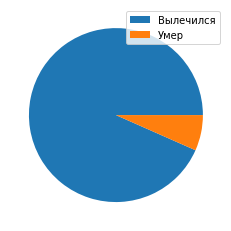

In [ ]:
plt.pie(info_df["outcome_tar"].value_counts())
plt.legend(["Вылечился", "Умер"])
plt.show()

### DAta preparation

Divide observations on train and test parts. We take some part as train period and next as test period. So we have X as (, WINDOW, PARAMS) and y (PARAMS)

In [ ]:
#module divides on X [[1, 2, 3, 4]] and y [5]
WINDOW = 3
PARAMS_LENGTH = 13

def df_to_X_y(df, window_per):
    X = []
    y = []
    for i in df.index.levels[0]:
        i_l = df.loc[(i)].index
        if (len(i_l) < window_per+1):
            continue
        X.append(df.loc[(i, 0):(i, window_per-1)].to_numpy(dtype="float64"))
        y.append(df.loc[(i, window_per)].to_numpy(dtype="float64"))
    return X, y

X, y = df_to_X_y(dinam_fact_df, WINDOW)
X_to_sc = np.array(X).reshape(-1, PARAMS_LENGTH)
y = np.array(y)

Impute NaN values using MICE methods with Linear regression as estimator 

In [143]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
imp = IterativeImputer(estimator=lr, missing_values=np.nan, max_iter=10, imputation_order='roman', random_state=0)
X_ex=imp.fit_transform(X_to_sc)
y_ex=imp.fit_transform(y)


[IterativeImputer] Completing matrix with shape (1590, 13)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.11
[IterativeImputer] Change: 1299.9491537597714, scaled tolerance: 1.93637 
[IterativeImputer] Ending imputation round 2/10, elapsed time 0.14
[IterativeImputer] Change: 58.92997461650057, scaled tolerance: 1.93637 
[IterativeImputer] Ending imputation round 3/10, elapsed time 0.16
[IterativeImputer] Change: 24.639577197095317, scaled tolerance: 1.93637 
[IterativeImputer] Ending imputation round 4/10, elapsed time 0.19
[IterativeImputer] Change: 12.245414542932545, scaled tolerance: 1.93637 
[IterativeImputer] Ending imputation round 5/10, elapsed time 0.21
[IterativeImputer] Change: 8.676238925818295, scaled tolerance: 1.93637 
[IterativeImputer] Ending imputation round 6/10, elapsed time 0.23
[IterativeImputer] Change: 6.283088138503002, scaled tolerance: 1.93637 
[IterativeImputer] Ending imputation round 7/10, elapsed time 0.25
[IterativeImputer] Change: 4.56

Norm data by Standart Scaler and divide and train test parts

In [ ]:
scal_model = StandardScaler().fit(X_ex)
X_scaled = scal_model.transform(X_ex)
y_scaled = scal_model.transform(y_ex)
X_scaled_divided = np.array(X_scaled).reshape(-1, WINDOW, PARAMS_LENGTH)
y_scaled_divided = np.array(y_scaled).reshape(-1, PARAMS_LENGTH)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_divided, y_scaled_divided)
X_train = X_train[:-1] # To DIVIDE on BATCHes
y_train = y_train[:-1]
BATCH_SIZE = 36

### Training

Start with one layer RNN size 13

1. RNN with h size 13

In [ ]:
model_simple_rnn_13 = Sequential()
model_simple_rnn_13.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model_simple_rnn_13.add(LSTM(WINDOW, activation="relu", return_sequences=False))
model_simple_rnn_13.compile(loss="mse", metrics=[RootMeanSquaredError()])
model_simple_rnn_13.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (36, 3)                   204       
                                                                 
Total params: 204
Trainable params: 204
Non-trainable params: 0
_________________________________________________________________


In [142]:
history = model_simple_rnn_13.fit(X_train, y_train, validation_split=0.15,  epochs=50, batch_size=BATCH_SIZE, shuffle=False)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])

Epoch 1/50


ValueError: in user code:

    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\losses.py", line 1486, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 3 and 13 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential_10/lstm_8/strided_slice_3, IteratorGetNext:1)' with input shapes: [36,3], [?,13].


In [1]:
X_test = X_test[:-1]
y_test = y_test[:-1]

NameError: name 'X_test' is not defined

In [163]:
model_simple_rnn_13.evaluate(X_test, y_test, batch_size=12)

 1/12 [=>............................] - ETA: 0s - loss: 0.4630 - root_mean_squared_error: 0.6805

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_28/lstm_33/TensorArrayUnstack/TensorListFromTensor' defined at (most recent call last):
    File "c:\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Python310\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
      app.start()
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Python310\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "c:\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "c:\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\sirau\AppData\Local\Temp\ipykernel_1428\3899891647.py", line 1, in <cell line: 1>
      model.evaluate(X_test, y_test)
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1947, in evaluate
      tmp_logs = self.test_function(iterator)
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1727, in test_function
      return step_function(self, iterator)
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1713, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1701, in run_step
      outputs = model.test_step(data)
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1665, in test_step
      y_pred = self(x, training=False)
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\layers\rnn\base_rnn.py", line 553, in __call__
      return super().__call__(inputs, **kwargs)
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\layers\rnn\lstm.py", line 625, in call
      last_output, outputs, states = backend.rnn(
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\backend.py", line 4939, in rnn
      input_ta = tuple(
    File "C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\backend.py", line 4940, in <genexpr>
      ta.unstack(input_)
Node: 'sequential_28/lstm_33/TensorArrayUnstack/TensorListFromTensor'
Specified a list with shape [12,13] from a tensor with shape [1,13]
	 [[{{node sequential_28/lstm_33/TensorArrayUnstack/TensorListFromTensor}}]] [Op:__inference_test_function_153268]

In [139]:
X_test_0 = scal_model.transform(X_test[0])
y_pred_0 = model_simple_rnn_13.predict(np.array([X_test_0]*12))
y_pred_0_inv = scal_model.inverse_transform(y_pred_0)
print("Real values")
print(y_pred_0_inv[0])
print("Predicted values")
print(scal_model.inverse_transform([y_test[0]]))

1/1 [==============================] - 0s 240ms/step
[3.6656002e+01 1.9088869e+00 4.1575275e+01 3.3184763e+03 4.4696564e+02
 1.0150840e+01 9.5894318e+00 1.2056466e+00 1.8785353e+02 9.8113209e-02
 3.4515724e+00 3.4722778e+02 2.5684128e+02]
[[3.65000000e+01 2.61000000e+00 4.15000000e+01 7.88593272e+01
  1.80000000e+01 1.56119544e+01 1.04000000e+01 1.60000000e-01
  2.72000000e+01 0.00000000e+00 1.00000000e+00 4.61000000e+02
  1.19000000e+01]]
